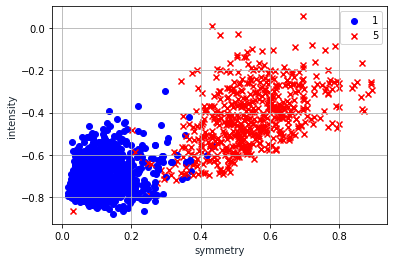

In [3]:
import pandas as pd
from matplotlib import pyplot

#importing training sets

trainFile = open("./Digits/ZipDigits.train")
train = trainFile.read()

#preprocessing: splitting by rows (individual digits' data)
train_rows_raw = train.split('\n')
train_rows_raw.pop(len(train_rows_raw)-1)
train_rows = []

#preprocessing: splitting data within each digits' set and saving only data for '1' and '5', labeled as 1 and -1 
#respectively
for j in range(0, len(train_rows_raw)):
    if train_rows_raw[j][0][0] == '5' or train_rows_raw[j][0][0] == '1':
        split = train_rows_raw[j].split(' ')
        if train_rows_raw[j][0][0] == '5':
            split[0] = -1.0
        else:
            split[0] = 1.0
        train_rows.append(split[0:257])
        
#extracting symmetry and intensity features for training set
for z in range(0,len(train_rows)):
    tot_sym = 0
    tot_int = 0
    #matrices used to store left and right halves of each digit
    left_train = [[0] * 8 for _ in range(16)]
    right_train = [[0] * 8 for _ in range(16)]
    #loop over rows of each digit
    for x in range(0,16):
        #loop through each pixel on each row and store in left and right halves, sum up vals for intensity
        for y in range(0,16):
            tot_int += float(train_rows[z][16*x+y+1])
            if y < 8:
                left_train[x][y] = float(train_rows[z][16*x+y+1])
            else:
                right_train[x][y-8] = float(train_rows[z][16*x+y+1])
        #compare left and right halves for each pixel in a row, keep total absolute values of differences
        for i in range(0,8):
            tot_sym += abs(left_train[x][i] - right_train[x][7-i])
    #getting the final symmetry value for each image
    sym = tot_sym/128
    #getting the final intensity value for each image
    intens = tot_int/256
    #appending extracted values to data
    train_rows[z].append(sym)
    train_rows[z].append(intens)

    
#format data in list of [sym, intensity, class] for each training example to pass into gradient descent
nnD = []
for t in range(0,len(train_rows)):
    samp = []
    samp.append(train_rows[t][257])
    samp.append(train_rows[t][258])
    samp.append(train_rows[t][0])
    nnD.append(samp)    
    
#rest of code is plotting points
#plotting symmetry (x-axis) by intensity (y-axis) in scatter.  Marking differently based on whether a '1' or '5'
for r in range(0, len(train_rows)):
    if train_rows[r][0] == 1:
        one = pyplot.scatter(train_rows[r][257], train_rows[r][258], marker = 'o', color = 'blue', label = '1')
    else:
        five = pyplot.scatter(train_rows[r][257], train_rows[r][258], marker = 'x', color = 'red', label = '5')

pyplot.xlabel('symmetry', color='#1C2833')
pyplot.ylabel('intensity', color='#1C2833')
pyplot.legend((one, five),
          ('1', '5'),
          loc = 'best')
pyplot.grid()
pyplot.show()


In [4]:
#Neural Network forward propagation and back propagation for 
#                                   2-layers with hidden layer containing m neurons)



import numpy as np
import itertools

#forward propagation algorithm 
def forProp(x_data, m=3, w=[0]):
    #if running for first time, initialize W^1 to small random non-zero values, so that tanh(w^Tx) is close to 0
    #initialize so weights match up with number of neurons in the hidden layer
    if len(w) < 2:
        w_bot = []
        w_mid = []
        w_top = []
        for i in range(0,m-1):
            w_top.append(0.0004)
            w_mid.append(-0.0002/x_data[0])
            w_bot.append(-0.0001/x_data[1])
        w.append([w_top, w_mid, w_bot])

    #set x for layer 0 (input layer)
    x = [[1, x_data[0], x_data[1]]]
    s = [[0]]
    for l in range(1,3):
        #calculate s for each layer
        s.append(np.dot(np.array(w[l]).T, np.array(x[l-1])))
        
        #use tanh activation function to obtain x, and add 1 in front representing bias neuron if not at last layer
        next_x = np.tanh(s[l]).tolist()
        if l != 2:
            next_x.insert(0,1)
        x.append(next_x)
        
        #initialize W^2 if first time running
        if(len(w)<3):
            next_w = []
            for i in range(0, m):
                if i == 0:
                    next_w.append(((m+1)*0.0001)/x[l][i])
                else:
                    next_w.append(((m-i)*(-0.0001))/x[l][i])
            w.append(next_w)

    return s, x, w

#Backpropagation to compute sensitivities d^l
def backProp(x_data, y_data, m=3, w = [0]):
    #get s, x, and w (if not initialized) from forward propagation
    s, x, w = forProp(x_data, m, w)

    d = [0,0,0]
    
    #calculate d^L
    d[2] = 2*(x[2] - y_data)*(1-x[2]*x[2])

    #calculate the derivative of the activation function used in back prop for layer L
    x_b = x[1][1:]
    tpsl = [1 - x_b * x_b for x_b,x_b in zip(x_b,x_b)]

    #calculate the back-prop "input" to the hidden layer (multiply weight and sensitivity of layer in front)
    w_b = w[2][1:]
    right = [a*d[2] for a in w_b]
    
    #get the sensitivity value of the hidden layer
    d[1] = [tpsl*right for tpsl,right in zip(tpsl,right)]
    
    return x,d


In [5]:
#Python library for Vedic Math sutras.  Includes the addition sutra used in this experiment. 
#Full credit goes to https://github.com/techmoksha/vedic-py

# %load vedic.py
from itertools import chain
from math import pow


class VedicNumber:

	def __init__(self, num):
		if isinstance(num, int):
			num = str(num)
		self.num = num

	def __add__(self, other):
		return Ops.add([self, other])

	def __mul__(self, other):
		return Ops.multiply(self, other)

	def __sub__(self, other):
		return Ops.subtract(self, other)

	def __pow__(self, power, modulo=None):
		return Ops.pow(self, power)

	def __str__(self):
		return self.num


class Ops(object):

	@staticmethod
	def leftpad_zeroes(string, num):
		"""
		Left pad a string with number of 0s = num
		:param string: String to pad
		:param num: Number of 0s to prepend
		:return:
		"""
		output = ['0' for i in range(0, num)]
		output = "".join(output)
		return output + string

	@staticmethod
	def rightpad_zeroes(string, num):
		"""
		Right pad a string with number of 0s = num
		:param string: String to pad
		:param num: Number of 0s to append
		:return:
		"""
		output = ['0' for i in range(0, num)]
		output = "".join(output)
		return string + output

	@staticmethod
	# TODO handle negative numbers
	def add(nums):
		"""
		Performs addition of all numbers based on vedic addition sutra
		:param nums : Array of numbers to be added. Each number can be string or int or #VedicNumber
		:return: Result of addition as a #VedicNumber
		"""
		# Get digits in number Convert to string
		nums = list(map(lambda num: str(num) if isinstance(num, VedicNumber) or isinstance(num, int) else num, nums))
		# Get length of biggest number
		max_len = max([len(num) for num in nums])
		# Left pad where required
		nums = list(map(lambda num: Ops.leftpad_zeroes(num, max_len - len(num)), nums))

		# First one is added by default since at least one digit will be present
		part1 = str(sum([int(num[0]) for num in nums]))
		main_stack = list()
		# Append every character separately
		[main_stack.append(s) for s in part1]

		for idx in range(1, max_len):
			# Add x[0] with y[0], x[1] with y[1] and so on while combining
			part2 = sum([int(num[idx]) for num in nums])
			# Convert back to string
			part2 = str(part2)
			if len(part2) == 1:
				# Append it to part 1 (Combine op)
				main_stack.append(part2)
			else:
				# Add result to last digit of part 1 with carry from part2(Combine op)
				res = part2
				residual_stack = list()
				if len(res) == 1:
					residual_stack.append(part2[-1])
				# Till res is a single digit we need to recurse
				while len(res) > 1:
					part1 = main_stack.pop()
					res = str(int(part1) + int(part2[0]))
					residual_stack.append(part2[-1])
					if len(res) > 1:
						part2 = res
				main_stack.append(str(res))
				# Append residual stack
				main_stack = list(chain(main_stack, residual_stack))
				residual_stack = None
		return VedicNumber("".join(main_stack))

	@staticmethod
	def subtract(x, y):
		"""
		Performs subtraction of y from x based on vedic subtraction sutra
		:param x : Larger number. Can be string or int or #VedicNumber
		:param y : Smaller number. Can be string or int or #VedicNumber
		:return: Result of subtraction as #VedicNumber
		"""
		if isinstance(x, int) or isinstance(x, VedicNumber):
			x = str(x)
		if isinstance(y, int) or isinstance(y, VedicNumber):
			y = str(y)
		max_len = max(len(x), len(y))
		x = Ops.leftpad_zeroes(x, max_len - len(x))
		y = Ops.leftpad_zeroes(y, max_len - len(y))

		main_stack = list()
		found_conseq_digit = False
		inconseq_zeroes = 0
		main_stack.append(str(int(x[0]) - int(y[0])))

		for idx in range(1, max_len):
			num1 = int(x[idx])
			num2 = int(y[idx])

			if num1 < num2:
				# Pop off the earlier number
				top = main_stack.pop()
				# Reduce the previous number
				top = int(top) - 1
				main_stack.append(str(top))
				correction_stack = list()

				while top < 0:
					# Need to apply correction by adding negative number to 10
					# Pop off the top element and reduce by 1
					top = main_stack.pop()
					correction = 10 + int(top)
					# Since correction is applied, 1 has to be deducted from new top
					top = main_stack.pop()
					top = int(top) - 1
					main_stack.append(str(top))
					correction_stack.append(str(correction))
				main_stack = list(chain(main_stack, correction_stack))
				correction_stack = None
				# Add 10 to num1
				num1 += 10
			if found_conseq_digit is not True:
				# Check top element
				top_most = main_stack[-1]
				if top_most == '0':
					inconseq_zeroes += 1
				else:
					found_conseq_digit = True
			main_stack.append(str(num1 - num2))
		return VedicNumber("".join(main_stack[inconseq_zeroes:]))

	@staticmethod
	def multiply(x, y):
		"""
		Performs multiplication of x and y based on vedic general multiplication sutra
		:param x : Can be string int or #VedicNumber
		:param y : Can be string int or #VedicNumber
		:return: Result of multiplication as #VedicNumber
		"""
		if isinstance(x, int) or isinstance(x, VedicNumber):
			x = str(x)
		if isinstance(y, int) or isinstance(y, VedicNumber):
			y = str(y)
		max_len = max(len(x), len(y))
		x = Ops.leftpad_zeroes(x, max_len - len(x))
		y = Ops.leftpad_zeroes(y, max_len - len(y))

		# Results of individual cross multiples
		execution_dict = Ops.perform_mult(x, y, max_len)
		# Reduce to get final result
		return Ops.reduce(execution_dict)

	@staticmethod
	def perform_mult(x, y, max_len):
		# Number of steps will be 2 * num_digits - 1
		num_steps = (2 * max_len) - 1
		execution_dict = dict()

		# Steps are symmetrical on either side of halfway mark
		for idx in range(0, (num_steps >> 1) + 1):
			exec_result_lhs = 0
			exec_result_rhs = 0
			for i in range(0, idx + 1):
				exec_result_lhs += int(x[max_len - 1 - i]) * int(y[max_len - 1 - idx + i])
				exec_result_rhs += int(x[i]) * int(y[idx - i])
			execution_dict[idx + 1] = exec_result_lhs
			execution_dict[num_steps - idx] = exec_result_rhs

		return execution_dict

	@staticmethod
	def reduce(execution_dict):
		# print(execution_dict)
		# Final output stack
		result_stack = []
		carry = 0

		keys = execution_dict.keys()
		for i in range(1, len(keys) + 1):
			top = execution_dict[i]
			# Add carry to it if present
			top = str(int(top) + int(carry))
			# Reset carry
			carry = 0
			if len(top) > 1:
				result_stack.append(top[-1])
				# Push other part to carry
				carry = top[:-1]
			else:
				result_stack.append(top)
		# If any carry remains we need to push that as well
		if carry != 0:
			result_stack.append(carry)
		output = []
		found_consequent_digit = False

		while len(result_stack) > 0:
			top = result_stack.pop()
			# Do not append inconsequential zeroes
			if int(top) > 0:
				found_consequent_digit = True
			if found_consequent_digit:
				output.append(top)
		return VedicNumber("".join(output))

	@staticmethod
	def fact(num):
		result = VedicNumber(2)
		for i in range(3, num + 1):
			result *= VedicNumber(i)
		return result

	@staticmethod
	def duplex(num):
		if isinstance(num, int) or isinstance(num, VedicNumber):
			num = str(num)
		# Convert to constituent digits
		num_digits = list(num)
		num_digits = list(map(lambda digit: int(digit), num_digits))
		length = len(num_digits)
		duplex = 0
		if length % 2 != 0:
			# Duplex is calculated as m ** 2 + 2 * a * b for odd digit numbers
			duplex = int(pow(num_digits[int(length / 2)], 2))
		duplex += 2 * sum([num_digits[i] * num_digits[length - 1 - i] for i in range(0, int(length / 2))])
		return duplex

	@staticmethod
	def pow(num, power):
		if power == 2:
			return Ops.sq(num)

	@staticmethod
	def sq(num):
		"""
		Performs square of this number based on vedic square sutra
		:return: Result of square as #VedicNumber
		"""
		if isinstance(num, int) or isinstance(num, VedicNumber):
			num = str(num)
		length = len(num)
		duplexes = dict()
		for i in range(1, length + 1):
			duplexes[(2 * length) - i] = Ops.duplex(num[0:i])
			duplexes[i] = Ops.duplex(num[length - i:length])
		# Reduce the duplex dict to single number
		return Ops.reduce(duplexes)


In [6]:
#Gradient Descent Normal implementation


def gD(D, m=10, w = [0]):
    #initialize E_in, G
    E_in = 0
    
    #G initialized specifically to correspond to shape of this neural network
    G = [0,[0,0,0],0]
    
    
    for n in range(0, len(D)):
        #get x values from forward prop and sensitivities d from backProp (calling backProp calls both sequentially)
        x, d = backProp(D[n][0:2], D[n][2], m, w)
        
        #using sign function on output layer to determine E_in
        if (x[2]>0 and D[n][2]<0) or (x[2]<0 and D[n][2]>0):
            E_in = E_in+1

        for l in range(1, 3):
            Gx = np.multiply(np.array(x[l-1]).reshape(-1,1), np.array(d[l]).reshape(1,-1)).tolist()

            #we have 2 units (not including bias) at the input layer and m units in the hidden layer.  
            #Thus W[1] will have 3 lists containing m-1 weights each.  To add the gradient, we have to 
            #explicitly shape our gradient similarly which the following code does
            if l == 1:     
                #if this is the first data point in this iteration, our G[1] does not contain 3 lists yet
                if type(G[l][0]) != list:
                    #specialized Python syntax to add lists w/o errors
                    #accounts for 3 lists in the first layer
                    for sp in range(0,3):     
                        G[l][sp] = [G[l][sp] + (1/len(D))*g_new for g_new in Gx[sp]]
                else:
                    #specialized Python syntax to add lists w/o errors
                    #accounts for 3 lists in the first layer
                    for sp in range(0,3):     
                        G[l][sp] = [g_old + (1/len(D))*g_new for g_old, g_new in zip(G[l][sp],Gx[sp])]
            else:
                #if we are in layer 2, W[2] is a single list of m weights.  We use the following
                #itertools library to concatenate the Gx[2] values into a single list
                Gx = list(itertools.chain.from_iterable(Gx))
                
                #same procedure as above
                if type(G[l]) != list:
                    G[l] = [G[l] + (1/len(D))*g_new for g_new in Gx]
                else:
                    G[l] = [g_old + (1/len(D))*g_new for g_old, g_new in zip(G[l],Gx)]
    E_in = E_in/len(D)
    return E_in, G, w

In [26]:
#Gradient Descent Vedic implementation
import math  


def gDV(D, m=10, w = [0]):
    #initialize E_in, G
    E_in = 0
    
    #G initialized specifically to correspond to shape of this neural network
    G = [VedicNumber(0),[VedicNumber(0),VedicNumber(0),VedicNumber(0)],VedicNumber(0)]

    
    for n in range(0, len(D)):
        #get x values from forward prop and sensitivities d from backProp (calling backProp calls both sequentially)
        x, d = backProp(D[n][0:2], D[n][2], m, w)
        
        #using sign function on output layer to determine E_in
        if (x[2]>0 and D[n][2]<0) or (x[2]<0 and D[n][2]>0):
            E_in = E_in+1

        for l in range(1, 3):
            Gx = np.multiply(np.array(x[l-1]).reshape(-1,1), np.array(d[l]).reshape(1,-1)).tolist()

            #Vedic Number library has some bugs and limitations.  We modify gradient descent to implement it as far
            #as possible
            
            #due to limitations of Vedic Number library, we can't add non-Vedic types with Vedic types. Hence, 
            #for the purposes of a proof of concept, we skip updating layer 1 of the gradients
            if l == 1:     
                continue;

            else:
                #if we are in layer 2, W[2] is a single list of m weights.  We use the following
                #itertools library to concatenate the Gx[2] values into a single list
                Gx = list(itertools.chain.from_iterable(Gx))
                
                #if this is the first data point in this iteration, our G[1] does not contain a lists yet
                if type(G[l]) != list:
                    #VEDIC ADDITION BEING USED
                    print('Vedic addition being used!')
                    G[l] = [G[l] + VedicNumber(abs(math.floor((1/len(D))*g_new))) for g_new in Gx]


    E_in = E_in/len(D)
    return E_in, G, w

In [27]:
#Gradient Descent Placebo implementation: matching Vedic version without using the Vedic Number library
def gDP(D, m=10, w = [0]):
    #initialize E_in, G
    E_in = 0
    
    #G initialized specifically to correspond to shape of this neural network
    G = [0,[0,0,0],0]
    
    for n in range(0, len(D)):
        #get x values from forward prop and sensitivities d from backProp (calling backProp calls both sequentially)
        x, d = backProp(D[n][0:2], D[n][2], m, w)
        
        #using sign function on output layer to determine E_in
        if (x[2]>0 and D[n][2]<0) or (x[2]<0 and D[n][2]>0):
            E_in = E_in+1

        for l in range(1, 3):
            Gx = np.multiply(np.array(x[l-1]).reshape(-1,1), np.array(d[l]).reshape(1,-1)).tolist()
            
            #matching modified GD in Vedic version above
            if l == 1:     
                continue;
            else:
                #if we are in layer 2, W[2] is a single list of m weights.  We use the following
                #itertools library to concatenate the Gx[2] values into a single list
                Gx = list(itertools.chain.from_iterable(Gx))
                
                #if this is the first data point in this iteration, our G[1] does not contain a lists yet
                if type(G[l]) != list:
                    G[l] = [G[l] + abs(math.floor((1/len(D))*g_new)) for g_new in Gx]
    E_in = E_in/len(D)
    return E_in, G, w

In [30]:
%load_ext memory_profiler

print("NORMAL")
%time gD(nnD[::-1], 10, [0])

%timeit -r 2 -n 5 gD(nnD[::-1], 10, [0])

%memit gD(nnD[::-1], 10, [0])
print('\n\n')


print("VEDIC")
%time gDV(nnD[::-1], 10, [0])

%timeit -r 2 -n 5 gDV(nnD[::-1], 10, [0])


%memit gDV(nnD[::-1], 10, [0])
print('\n\n')



print("CONTROL")

%time gDP(nnD[::-1], 10, [0])

%timeit -r 2 -n 5 gDP(nnD[::-1], 10, [0])

%memit gDP(nnD[::-1], 10, [0])


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
NORMAL
CPU times: user 100 ms, sys: 13 ms, total: 113 ms
Wall time: 102 ms
89.1 ms ± 6.91 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)
peak memory: 192.31 MiB, increment: 0.00 MiB



VEDIC
Vedic addition being used!
CPU times: user 82.2 ms, sys: 9.27 ms, total: 91.5 ms
Wall time: 83.3 ms
Vedic addition being used!
Vedic addition being used!
Vedic addition being used!
Vedic addition being used!
Vedic addition being used!
Vedic addition being used!
Vedic addition being used!
Vedic addition being used!
Vedic addition being used!
Vedic addition being used!
77.2 ms ± 696 µs per loop (mean ± std. dev. of 2 runs, 5 loops each)
Vedic addition being used!
Vedic addition being used!
peak memory: 192.32 MiB, increment: 0.00 MiB



CONTROL
CPU times: user 86.9 ms, sys: 12 ms, total: 98.9 ms
Wall time: 88.1 ms
69.4 ms ± 5.98 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)
peak memory: 